<a href="https://colab.research.google.com/github/aghazahedim/How-Deep-is-Your-Art/blob/main/Custom_Split_UNIQUE_SEED_Jackson_Fine_Arts_4_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


 49% 5.00M/10.3M [00:01<00:01, 3.98MB/s]
100% 10.3M/10.3M [00:01<00:00, 7.88MB/s]
Number of training examples: 43
Number of validation examples: 5
Number of testing examples: 16
The model has 128,812,810 trainable parameters


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Stopping early, the loss has diverged


FileNotFoundError: ignored

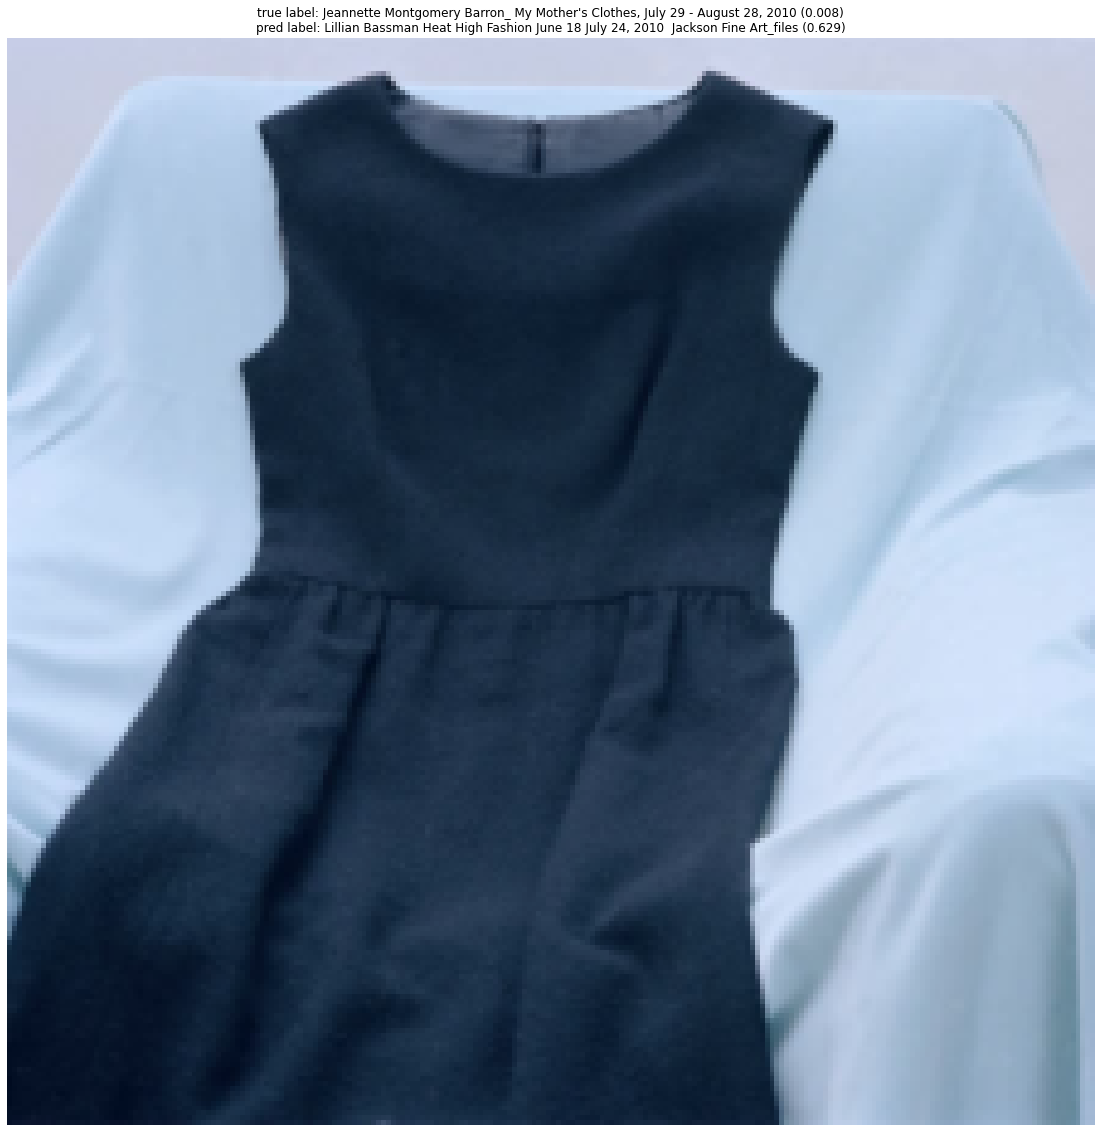

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time
import os
import shutil

results = []
TRAIN_RATIO = 0.8
ROOT = 'Easy'
min_seed = 1
max_seed = 10000
seed_list = [seed for seed in range(min_seed, max_seed+1)]

#REPLACE THESE WITH YOUR OWN KAGGLE USERNAME AND KEY
os.environ['KAGGLE_USERNAME'] = 'mahanaghazahedi'
os.environ['KAGGLE_KEY'] = 'd80595efb501bc1a22698fb1ab2e6017'

!pip install kaggle
!kaggle datasets download mahanaghazahedi/jfa2n3 --unzip

data_dir = ROOT
images_dir = os.path.join(data_dir, 'Dataset')
train_dir = os.path.join(data_dir, 'Train')
test_dir = os.path.join(data_dir, 'Test')
classes = os.listdir(images_dir)

os.makedirs('/content/drive/MyDrive/A(i) Curator/VGG/Ratio {j}_{ROOT}_UNIQUE SEED'.format(j = TRAIN_RATIO, ROOT = ROOT), exist_ok = True)

def VGG(num):
  SEED = seed_list.pop(random.randint(min_seed,len(seed_list)))

  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True

  train_data = datasets.ImageFolder(root = train_dir,
                                    transform = transforms.ToTensor())

  means = torch.zeros(3)
  stds = torch.zeros(3)

  for img, label in train_data:
      means += torch.mean(img, dim = (1,2))
      stds += torch.std(img, dim = (1,2))

  means /= len(train_data)
  stds /= len(train_data)
  '''
  print(f'Calculated means: {means}')
  print(f'Calculated stds: {stds}')
  '''

  pretrained_size = 224
  pretrained_means = [0.485, 0.456, 0.406]
  pretrained_stds= [0.229, 0.224, 0.225]

  train_transforms = transforms.Compose([
                            transforms.Resize(pretrained_size),
                            transforms.RandomRotation(5),
                            transforms.RandomHorizontalFlip(0.5),
                            transforms.RandomCrop(pretrained_size, padding = 10),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = pretrained_means,
                                                  std = pretrained_stds)
                        ])

  test_transforms = transforms.Compose([
                            transforms.Resize(pretrained_size),
                            transforms.CenterCrop(pretrained_size),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = pretrained_means,
                                                  std = pretrained_stds)
                        ])

  train_data = datasets.ImageFolder(root = train_dir,
                                    transform = train_transforms)

  test_data = datasets.ImageFolder(root = test_dir,
                                  transform = test_transforms)
  VALID_RATIO = 0.9

  n_train_examples = int(len(train_data) * VALID_RATIO)
  n_valid_examples = len(train_data) - n_train_examples

  train_data, valid_data = data.random_split(train_data,
                                            [n_train_examples, n_valid_examples])

  valid_data = copy.deepcopy(valid_data)
  valid_data.dataset.transform = test_transforms

  print(f'Number of training examples: {len(train_data)}')
  print(f'Number of validation examples: {len(valid_data)}')
  print(f'Number of testing examples: {len(test_data)}')

  def normalize_image(image):
      image_min = image.min()
      image_max = image.max()
      image.clamp_(min = image_min, max = image_max)
      image.add_(-image_min).div_(image_max - image_min + 1e-5)
      return image

  def plot_images(images, labels, classes, normalize = True):

      n_images = len(images)

      rows = int(np.sqrt(n_images))
      cols = int(np.sqrt(n_images))

      fig = plt.figure(figsize = (10, 10))

      for i in range(rows*cols):

          ax = fig.add_subplot(rows, cols, i+1)

          image = images[i]

          if normalize:
              image = normalize_image(image)

          ax.imshow(image.permute(1, 2, 0).cpu().numpy())
          ax.set_title(classes[labels[i]])
          ax.axis('off')

  N_IMAGES = 25

  images, labels = zip(*[(image, label) for image, label in
                            [train_data[i] for i in range(N_IMAGES)]])

  classes = test_data.classes

  #plot_images(images, labels, classes)

  BATCH_SIZE = 8

  train_iterator = data.DataLoader(train_data,
                                  shuffle = True,
                                  batch_size = BATCH_SIZE)

  valid_iterator = data.DataLoader(valid_data,
                                  batch_size = BATCH_SIZE)

  test_iterator = data.DataLoader(test_data,
                                  batch_size = BATCH_SIZE)

  ###
  class VGG(nn.Module):
      def __init__(self, features, output_dim):
          super().__init__()

          self.features = features

          self.avgpool = nn.AdaptiveAvgPool2d(7)

          self.classifier = nn.Sequential(
              nn.Linear(512 * 7 * 7, 4096),
              nn.ReLU(inplace = True),
              nn.Dropout(0.5),
              nn.Linear(4096, 4096),
              nn.ReLU(inplace = True),
              nn.Dropout(0.5),
              nn.Linear(4096, output_dim),
          )

      def forward(self, x):
          x = self.features(x)
          x = self.avgpool(x)
          h = x.view(x.shape[0], -1)
          x = self.classifier(h)
          return x, h

  vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512,
                  512, 'M']

  vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M',
                  512, 512, 512, 512, 'M']

  def get_vgg_layers(config, batch_norm):

      layers = []
      in_channels = 3

      for c in config:
          assert c == 'M' or isinstance(c, int)
          if c == 'M':
              layers += [nn.MaxPool2d(kernel_size = 2)]
          else:
              conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
              if batch_norm:
                  layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)]
              else:
                  layers += [conv2d, nn.ReLU(inplace = True)]
              in_channels = c

      return nn.Sequential(*layers)

  vgg11_layers = get_vgg_layers(vgg11_config, batch_norm = True)
  #print(vgg11_layers)

  OUTPUT_DIM = 10

  model = VGG(vgg11_layers, OUTPUT_DIM)

  #print(model)

  import torchvision.models as models

  pretrained_model = models.vgg11_bn(pretrained = True)

  #print(pretrained_model)

  pretrained_model.classifier[-1]

  IN_FEATURES = pretrained_model.classifier[-1].in_features

  final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

  pretrained_model.classifier[-1] = final_fc
  #print(pretrained_model.classifier)

  model.load_state_dict(pretrained_model.state_dict())

  def count_parameters(model):
      return sum(p.numel() for p in model.parameters() if p.requires_grad)

  print(f'The model has {count_parameters(model):,} trainable parameters')

  ##
  START_LR = 1e-7

  optimizer = optim.Adam(model.parameters(), lr = START_LR)

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  criterion = nn.CrossEntropyLoss()

  model = model.to(device)
  criterion = criterion.to(device)

  class LRFinder:
      def __init__(self, model, optimizer, criterion, device):

          self.optimizer = optimizer
          self.model = model
          self.criterion = criterion
          self.device = device

          torch.save(model.state_dict(), 'init_params.pt')

      def range_test(self, iterator, end_lr = 10, num_iter = 100,
                    smooth_f = 0.05, diverge_th = 5):

          lrs = []
          losses = []
          best_loss = float('inf')

          lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)

          iterator = IteratorWrapper(iterator)

          for iteration in range(num_iter):

              loss = self._train_batch(iterator)

              lrs.append(lr_scheduler.get_last_lr()[0])

              #update lr
              lr_scheduler.step()

              if iteration > 0:
                  loss = smooth_f * loss + (1 - smooth_f) * losses[-1]

              if loss < best_loss:
                  best_loss = loss

              losses.append(loss)

              if loss > diverge_th * best_loss:
                  print("Stopping early, the loss has diverged")
                  break

          #reset model to initial parameters
          model.load_state_dict(torch.load('init_params.pt'))


          return lrs, losses

      def _train_batch(self, iterator):

          self.model.train()

          self.optimizer.zero_grad()

          x, y = iterator.get_batch()

          x = x.to(self.device)
          y = y.to(self.device)

          y_pred, _ = self.model(x)

          loss = self.criterion(y_pred, y)

          loss.backward()

          self.optimizer.step()

          return loss.item()

  class ExponentialLR(_LRScheduler):
      def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
          self.end_lr = end_lr
          self.num_iter = num_iter
          super(ExponentialLR, self).__init__(optimizer, last_epoch)

      def get_lr(self):
          curr_iter = self.last_epoch
          r = curr_iter / self.num_iter
          return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

  class IteratorWrapper:
      def __init__(self, iterator):
          self.iterator = iterator
          self._iterator = iter(iterator)

      def __next__(self):
          try:
              inputs, labels = next(self._iterator)
          except StopIteration:
              self._iterator = iter(self.iterator)
              inputs, labels, *_ = next(self._iterator)

          return inputs, labels

      def get_batch(self):
          return next(self)
  #
  END_LR = 10
  NUM_ITER = 100

  lr_finder = LRFinder(model, optimizer, criterion, device)
  lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

  def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):

      if skip_end == 0:
          lrs = lrs[skip_start:]
          losses = losses[skip_start:]
      else:
          lrs = lrs[skip_start:-skip_end]
          losses = losses[skip_start:-skip_end]

      fig = plt.figure(figsize = (16,8))
      ax = fig.add_subplot(1,1,1)
      ax.plot(lrs, losses)
      ax.set_xscale('log')
      ax.set_xlabel('Learning rate')
      ax.set_ylabel('Loss')
      ax.grid(True, 'both', 'x')
      plt.show()


  #plot_lr_finder(lrs, losses, skip_start = 10, skip_end = 20)

  FOUND_LR = 5e-4

  params = [
            {'params': model.features.parameters(), 'lr': FOUND_LR / 10},
            {'params': model.classifier.parameters()}
          ]

  optimizer = optim.Adam(params, lr = FOUND_LR)

  def calculate_accuracy(y_pred, y):
      top_pred = y_pred.argmax(1, keepdim = True)
      correct = top_pred.eq(y.view_as(top_pred)).sum()
      acc = correct.float() / y.shape[0]
      return acc

  def train(model, iterator, optimizer, criterion, device):

      epoch_loss = 0
      epoch_acc = 0

      model.train()

      for (x, y) in iterator:

          x = x.to(device)
          y = y.to(device)

          optimizer.zero_grad()

          y_pred, _ = model(x)

          loss = criterion(y_pred, y)

          acc = calculate_accuracy(y_pred, y)

          loss.backward()

          optimizer.step()

          epoch_loss += loss.item()
          epoch_acc += acc.item()

      return epoch_loss / len(iterator), epoch_acc / len(iterator)

  def evaluate(model, iterator, criterion, device, seed):

      epoch_loss = 0
      epoch_acc = 0

      model.eval()

      with torch.no_grad():

          for (x, y) in iterator:

              x = x.to(device)
              y = y.to(device)

              y_pred, _ = model(x)

              loss = criterion(y_pred, y)

              acc = calculate_accuracy(y_pred, y)

              epoch_loss += loss.item()
              epoch_acc += acc.item()

      if seed:
        return epoch_loss / len(iterator), epoch_acc / len(iterator), SEED
      else:
        return epoch_loss / len(iterator), epoch_acc / len(iterator)

  def epoch_time(start_time, end_time):
      elapsed_time = end_time - start_time
      elapsed_mins = int(elapsed_time / 60)
      elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
      return elapsed_mins, elapsed_secs

  EPOCHS = 10

  best_valid_loss = float('inf')

  for epoch in range(EPOCHS):

      start_time = time.monotonic()

      train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
      valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device, False)

      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(model.state_dict(), 'tut4-model.pt')

      end_time = time.monotonic()

      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      '''
      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
      '''
  #
  model.load_state_dict(torch.load('tut4-model.pt'))
  results.append(evaluate(model, test_iterator, criterion, device, True))
  #test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

  #print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

  def get_predictions(model, iterator):

      model.eval()

      images = []
      labels = []
      probs = []

      with torch.no_grad():

          for (x, y) in iterator:

              x = x.to(device)

              y_pred, _ = model(x)

              y_prob = F.softmax(y_pred, dim = -1)
              top_pred = y_prob.argmax(1, keepdim = True)

              images.append(x.cpu())
              labels.append(y.cpu())
              probs.append(y_prob.cpu())

      images = torch.cat(images, dim = 0)
      labels = torch.cat(labels, dim = 0)
      probs = torch.cat(probs, dim = 0)

      return images, labels, probs

  images, labels, probs = get_predictions(model, test_iterator)
  pred_labels = torch.argmax(probs, 1)

  def plot_confusion_matrix(labels, pred_labels, classes):

      fig = plt.figure(figsize = (10, 10));
      ax = fig.add_subplot(1, 1, 1);
      cm = confusion_matrix(labels, pred_labels);
      cm = ConfusionMatrixDisplay(cm, display_labels = classes);
      cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
      plt.xticks(rotation = 20)

  #plot_confusion_matrix(labels, pred_labels, classes)

  corrects = torch.eq(labels, pred_labels)

  incorrect_examples = []

  for image, label, prob, correct in zip(images, labels, probs, corrects):
      if not correct:
          incorrect_examples.append((image, label, prob))

  incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

  def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

      rows = n_images#int(np.sqrt(n_images))
      cols = 1 #int(np.sqrt(n_images))

      fig = plt.figure(figsize = (25, 20))

      for i in range(rows*cols):

          ax = fig.add_subplot(rows, cols, i+1)

          image, true_label, probs = incorrect[i]
          image = image.permute(1, 2, 0)
          true_prob = probs[true_label]
          incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
          true_class = classes[true_label]
          incorrect_class = classes[incorrect_label]

          if normalize:
              image = normalize_image(image)

          ax.imshow(image.cpu().numpy())
          ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                      f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
          ax.axis('off')

      fig.subplots_adjust(hspace = 0.4)
      fig.savefig('/content/drive/MyDrive/A(i) Curator/VGG/Ratio {j}_{ROOT}_UNIQUE SEED/most incorrect {i}.png'.format(ROOT = ROOT,i = num, j = TRAIN_RATIO))

  N_IMAGES = len(incorrect_examples)
  plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

'''
  def get_representations(model, iterator):

      model.eval()

      outputs = []
      intermediates = []
      labels = []

      with torch.no_grad():

          for (x, y) in iterator:

              x = x.to(device)

              y_pred, _ = model(x)

              outputs.append(y_pred.cpu())
              labels.append(y)

      outputs = torch.cat(outputs, dim = 0)
      labels = torch.cat(labels, dim = 0)

      return outputs, labels

  outputs, labels = get_representations(model, train_iterator)

  def get_pca(data, n_components = 2):
      pca = decomposition.PCA()
      pca.n_components = n_components
      pca_data = pca.fit_transform(data)
      return pca_data

  def plot_representations(data, labels, classes, n_images = None):

      if n_images is not None:
          data = data[:n_images]
          labels = labels[:n_images]

      fig = plt.figure(figsize = (10, 10))
      ax = fig.add_subplot(111)
      scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
      handles, labels = scatter.legend_elements()
      legend = ax.legend(handles = handles, labels = classes)

  output_pca_data = get_pca(outputs)
  #plot_representations(output_pca_data, labels, classes)

  def get_tsne(data, n_components = 2, n_images = None):

      if n_images is not None:
          data = data[:n_images]

      tsne = manifold.TSNE(n_components = n_components, random_state = 0)
      tsne_data = tsne.fit_transform(data)
      return tsne_data

  N_IMAGES = 5_000

  output_tsne_data = get_tsne(outputs, n_images = N_IMAGES)
  #plot_representations(output_tsne_data, labels, classes, n_images = N_IMAGES)

  def plot_filtered_images(images, filters, n_filters = None, normalize = True):

      images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
      filters = filters.cpu()

      if n_filters is not None:
          filters = filters[:n_filters]

      n_images = images.shape[0]
      n_filters = filters.shape[0]

      filtered_images = F.conv2d(images, filters)

      fig = plt.figure(figsize = (30, 30))

      for i in range(n_images):

          image = images[i]

          if normalize:
              image = normalize_image(image)

          ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
          ax.imshow(image.permute(1,2,0).numpy())
          ax.set_title('Original')
          ax.axis('off')

          for j in range(n_filters):
              image = filtered_images[i][j]

              if normalize:
                  image = normalize_image(image)

              ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
              ax.imshow(image.numpy(), cmap = 'bone')
              ax.set_title(f'Filter {j+1}')
              ax.axis('off');

      fig.subplots_adjust(hspace = -0.7)

  N_IMAGES = 5
  N_FILTERS = 7

  images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
  filters = model.features[0].weight.data

  #plot_filtered_images(images, filters, N_FILTERS)

  def plot_filters(filters, normalize = True):

      filters = filters.cpu()

      n_filters = filters.shape[0]

      rows = int(np.sqrt(n_filters))
      cols = int(np.sqrt(n_filters))

      fig = plt.figure(figsize = (20, 10))

      for i in range(rows*cols):

          image = filters[i]

          if normalize:
              image = normalize_image(image)

          ax = fig.add_subplot(rows, cols, i+1)
          ax.imshow(image.permute(1, 2, 0))
          ax.axis('off')

      fig.subplots_adjust(wspace = -0.9)
'''
  #plot_filters(filters)

for i in range(15):
  VGG(i)


print(results)

import csv
with open('/content/drive/MyDrive/A(i) Curator/VGG/Ratio {j}_{ROOT}_UNIQUE SEED/VGG_{TRAIN_RATIO}_{ROOT}_results.csv'.format(ROOT = ROOT,TRAIN_RATIO = TRAIN_RATIO, j = TRAIN_RATIO),'w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['test_loss', 'test_acc_1', 'Seed'])
    for row in results:
        csv_out.writerow(row)


In [ ]:
import os
#os.makedirs('/content/drive/MyDrive/A(i) Curator/VGG/Ratio {j}'.format(j = TRAIN_RATIO), exist_ok = True)
import csv
with open('/content/drive/MyDrive/A(i) Curator/VGG/Ratio {j}_{ROOT}_UNIQUE SEED/VGG_{TRAIN_RATIO}_{ROOT}_results.csv'.format(ROOT = ROOT,TRAIN_RATIO = TRAIN_RATIO, j = TRAIN_RATIO),'w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['test_loss', 'test_acc_1'])
    for row in results:
        csv_out.writerow(row)

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7410 sha256=e015b7275099f50e79d1e379a30ac41b369efe9f01d67dee79ee03a1a0222226
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Gen RAM Free: 22.9 GB  |     Proc size: 5.6 GB
GPU RAM Free: 21MB | Used: 16139MB | Util 100% | Total     16160MB
